# Training Mixture-of-Experts

## Imports

In [1]:
import sys
sys.path.append('../')

In [2]:
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

from etl.dataloader import CombinedExpertDataset

from moe import MixtureOfExperts

from sklearn.model_selection import train_test_split

## Loading Dataset

See `etl` module for more details.

In [3]:
df = pd.read_csv('features/target.csv')
# Split into train (80%) and test (20%) sets
df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)

# Reset indices
df_train = df_train.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [4]:
# Create dataset
train_dataset = CombinedExpertDataset(df_train)
test_dataset = CombinedExpertDataset(df_test)

/Users/shishiraravindan/Documents/college/CSC413/nfl-prediction-MoE/demo/../etl/dataloader.py:189: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:281.)
  self.cnn_features = torch.tensor(self.cnn_features, dtype=torch.float32) / 255.0  # normalize to [0,1]


In [5]:
# Custom collate function
def collate_fn(batch):
    keys, batch_data, targets = zip(*batch)
    batched_data = {
        'cnn': torch.stack([item['cnn'] for item in batch_data]),
        'mlp': torch.stack([item['mlp'] for item in batch_data]),
        'rnn': torch.stack([item['rnn'] for item in batch_data])
    }
    targets = torch.stack(targets)
    return keys, batched_data, targets

In [6]:
# Create dataloaders
batch_size = 32

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_fn
)
test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_fn
)

In [7]:
print(f'Train Set:  {len(train_loader.dataset)} samples')
print(f'Test Set:   {len(test_loader.dataset)} samples')

Train Set:  10045 samples
Test Set:   2543 samples


## Mixture of Experts
Initialize the MoE model with pretrained experts. Uses a gating network to combine the predictions of the experts. See `experts` module for more details.

In [8]:
moe = MixtureOfExperts()

/Users/shishiraravindan/Documents/college/CSC413/nfl-prediction-MoE/demo/../experts/cnn.py:64: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(f'../che

In [17]:
from sklearn.metrics import f1_score

# Initialize metrics storage
losses = []
accuracies = []
f1_scores = []  # Initialize F1 score storage
expert_weights_history = []
expert_accuracies = {'cnn': [], 'rnn': [], 'mlp': []}  # Initialize expert accuracies dict

# Training setup
criterion = nn.BCELoss()
optimizer = optim.Adam(moe.gating_network.parameters(), lr=0.001)

l1_lambda=0.01

# Training loop
num_epochs = 10

for epoch in range(num_epochs):
    total_loss = 0
    correct = 0
    total = 0
    epoch_weights = []
    expert_correct = {'cnn': 0, 'rnn': 0, 'mlp': 0}
    all_predictions = []
    all_targets = []

    for keys, batch_data, targets in train_loader:
        # Get features from batch
        cnn_features = batch_data['cnn'].permute(0, 3, 1, 2)
        mlp_features = batch_data['mlp']
        rnn_features = batch_data['rnn']
        
        # Forward pass
        final_pred, expert_weights, expert_preds = moe(cnn_features, mlp_features, rnn_features)
        
        # Store expert weights
        epoch_weights.append(expert_weights.detach().mean(dim=0))
        
        # Calculate loss
        loss = criterion(final_pred, targets)

        # L1 regularization
        l1_norm = sum(p.abs().sum() for p in moe.gating_network.parameters())
        loss += l1_lambda * l1_norm  # Add L1 penalty

        # Backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Track metrics for final prediction
        predicted = (final_pred >= 0.5).float()
        correct += (predicted == targets).sum().item()
        total += targets.size(0)
        total_loss += loss.item()

        # Store predictions and targets for F1 score calculation
        all_predictions.extend(predicted.cpu().numpy())
        all_targets.extend(targets.cpu().numpy())

        # Track metrics for individual experts
        expert_correct['cnn'] += ((expert_preds['formation'] >= 0.5).float() == targets).sum().item()
        expert_correct['rnn'] += ((expert_preds['coordinator'] >= 0.5).float() == targets).sum().item()
        expert_correct['mlp'] += ((expert_preds['context'] >= 0.5).float() == targets).sum().item()

    # Calculate epoch metrics
    avg_loss = total_loss / len(train_loader)
    accuracy = 100 * correct / total
    f1 = f1_score(all_targets, all_predictions)  # Calculate F1 score
    avg_weights = torch.stack(epoch_weights).mean(dim=0)
    
    # Calculate expert accuracies
    for expert in expert_correct:
        expert_acc = 100 * expert_correct[expert] / total
        expert_accuracies[expert].append(expert_acc)
    
    # Store metrics
    losses.append(avg_loss)
    accuracies.append(accuracy)
    f1_scores.append(f1)  # Store F1 score
    expert_weights_history.append(avg_weights)
    
    # Print epoch statistics
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%, F1 Score: {f1:.4f}')
    print(f'\t\tExpert weights: CNN: {avg_weights[0]:.3f}, RNN: {avg_weights[1]:.3f}, MLP: {avg_weights[2]:.3f}')

Epoch [1/10], Loss: 0.6211, Accuracy: 67.39%, F1 Score: 0.7681
		Expert weights: CNN: 0.152, RNN: 0.074, MLP: 0.774
Epoch [2/10], Loss: 0.6207, Accuracy: 67.34%, F1 Score: 0.7676
		Expert weights: CNN: 0.142, RNN: 0.071, MLP: 0.787
Epoch [3/10], Loss: 0.6204, Accuracy: 67.35%, F1 Score: 0.7676
		Expert weights: CNN: 0.134, RNN: 0.072, MLP: 0.793
Epoch [4/10], Loss: 0.6200, Accuracy: 67.44%, F1 Score: 0.7681
		Expert weights: CNN: 0.127, RNN: 0.072, MLP: 0.801
Epoch [5/10], Loss: 0.6199, Accuracy: 67.34%, F1 Score: 0.7673
		Expert weights: CNN: 0.122, RNN: 0.073, MLP: 0.805
Epoch [6/10], Loss: 0.6196, Accuracy: 67.42%, F1 Score: 0.7678
		Expert weights: CNN: 0.116, RNN: 0.072, MLP: 0.812
Epoch [7/10], Loss: 0.6195, Accuracy: 67.41%, F1 Score: 0.7677
		Expert weights: CNN: 0.111, RNN: 0.073, MLP: 0.816
Epoch [8/10], Loss: 0.6193, Accuracy: 67.47%, F1 Score: 0.7680
		Expert weights: CNN: 0.106, RNN: 0.072, MLP: 0.821
Epoch [9/10], Loss: 0.6190, Accuracy: 67.30%, F1 Score: 0.7668
		Expert 

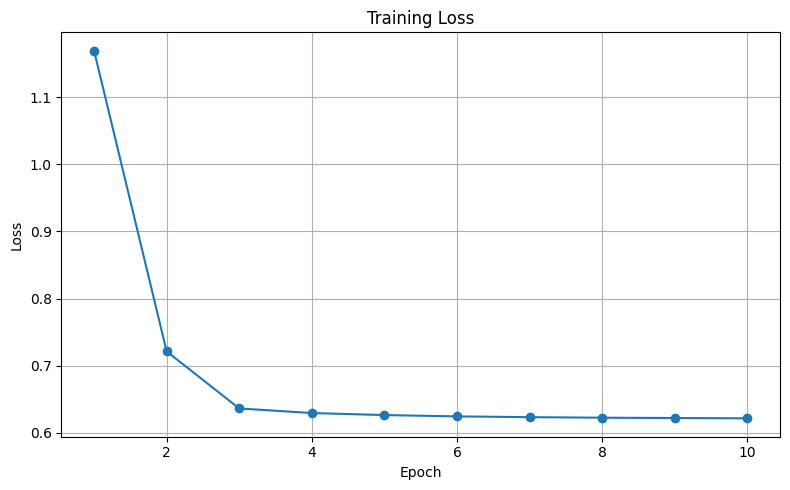

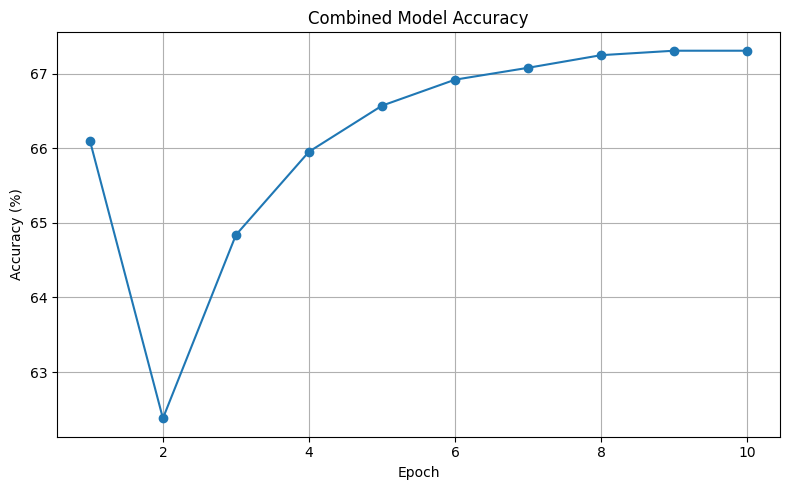

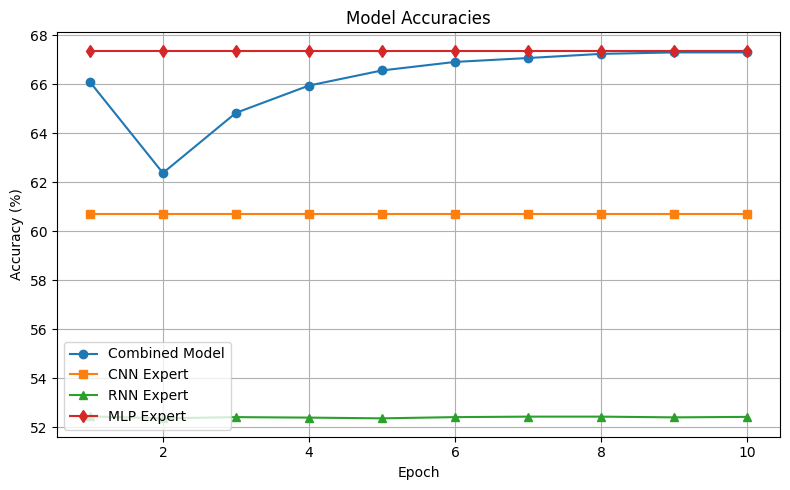

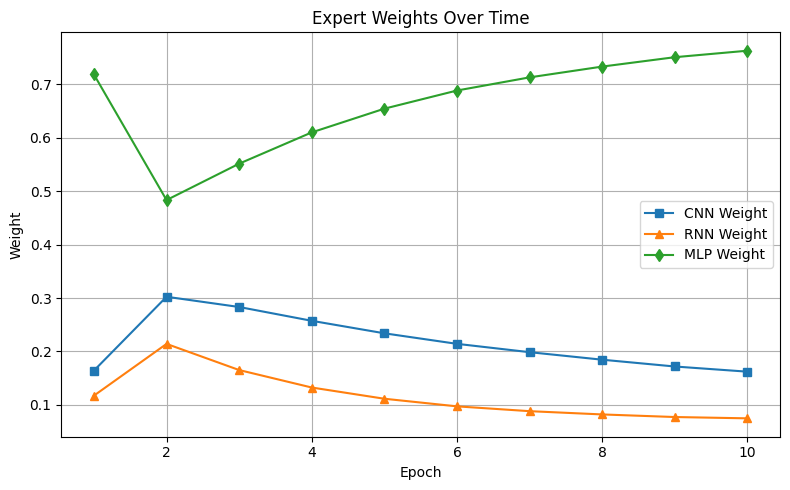

In [15]:
import matplotlib.pyplot as plt

def plot_training_loss(epochs, losses):
    plt.figure(figsize=(8, 5))
    plt.plot(range(1, epochs+1), losses, marker='o')
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_accuracy_comparison(epochs, accuracies, expert_accuracies):
    plt.figure(figsize=(8, 5))
    plt.plot(range(1, epochs+1), accuracies, marker='o', label='Combined Model')
    plt.plot(range(1, epochs+1), expert_accuracies['cnn'], marker='s', label='CNN Expert')
    plt.plot(range(1, epochs+1), expert_accuracies['rnn'], marker='^', label='RNN Expert') 
    plt.plot(range(1, epochs+1), expert_accuracies['mlp'], marker='d', label='MLP Expert')
    plt.title('Model Accuracies')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_expert_weights(epochs, expert_weights_history):
    plt.figure(figsize=(8, 5))
    plt.plot(range(1, epochs+1), [w[0] for w in expert_weights_history], marker='s', label='CNN Weight')
    plt.plot(range(1, epochs+1), [w[1] for w in expert_weights_history], marker='^', label='RNN Weight')
    plt.plot(range(1, epochs+1), [w[2] for w in expert_weights_history], marker='d', label='MLP Weight')
    plt.title('Expert Weights Over Time')
    plt.xlabel('Epoch')
    plt.ylabel('Weight')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_combined_accuracy(epochs, accuracies):
    plt.figure(figsize=(8, 5))
    plt.plot(range(1, epochs+1), accuracies, marker='o')
    plt.title('Combined Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Plot each metric separately
plot_training_loss(num_epochs, losses)
plot_combined_accuracy(num_epochs, accuracies)
plot_accuracy_comparison(num_epochs, accuracies, expert_accuracies)
plot_expert_weights(num_epochs, expert_weights_history)


In [18]:
from sklearn.metrics import f1_score

def evaluate_moe(moe, test_loader, criterion):
    """
    Evaluate MoE performance on test set
    Returns:
        float: Average loss
        float: Accuracy
        float: F1 Score
        dict: Average expert weights
    """
    total_loss = 0
    correct = 0
    total = 0
    expert_weights_sum = torch.zeros(3)  # For 3 experts
    num_batches = 0
    all_predictions = []
    all_targets = []
    
    with torch.no_grad():  # No gradients needed for evaluation
        for keys, batch_data, targets in test_loader:
            # Get features from batch
            cnn_features = batch_data['cnn'].permute(0, 3, 1, 2)  # Adjust for CNN input
            mlp_features = batch_data['mlp']
            rnn_features = batch_data['rnn']
            
            # Forward pass through MoE
            final_pred, expert_weights, _ = moe(
                cnn_features, 
                mlp_features, 
                rnn_features
            )
            
            # Calculate loss
            loss = criterion(final_pred, targets)
            
            # Track metrics
            total_loss += loss.item()
            predicted = (final_pred >= 0.5).float()
            correct += (predicted == targets).sum().item()
            total += targets.size(0)
            
            # Collect predictions and targets for F1 score
            all_predictions.extend(predicted.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())
            
            # Track expert weights
            expert_weights_sum += expert_weights.mean(dim=0)
            num_batches += 1
    
    # Calculate averages
    avg_loss = total_loss / num_batches
    accuracy = 100 * correct / total
    avg_expert_weights = expert_weights_sum / num_batches
    f1 = f1_score(all_targets, all_predictions)

    return avg_loss, accuracy, f1, {
        'cnn': avg_expert_weights[0].item(),
        'rnn': avg_expert_weights[1].item(),
        'mlp': avg_expert_weights[2].item()
    }

# Evaluate
val_loss, val_accuracy, val_f1, expert_weights = evaluate_moe(moe, test_loader, criterion)

# Print results
print("\nFinal Model Performance:")
print(f"Test Loss: {val_loss:.4f}")
print(f"Test Accuracy: {val_accuracy:.2f}%")
print(f"Test F1 Score: {val_f1:.2f}")
print("\nExpert Weights:")
for expert, weight in expert_weights.items():
    print(f"{expert.upper()}: {weight:.3f}")


Final Model Performance:
Test Loss: 0.7364
Test Accuracy: 57.14%
Test F1 Score: 0.69

Expert Weights:
CNN: 0.098
RNN: 0.075
MLP: 0.827
